# PM 2.5 Air Pollution Interpolation in Poland with Kriging (and IDW)

Notebook presents steps required to interpolate data at unknown locations with `Pyinterpolate` package. We create air pollution map with **inverse distance weighting** and **kriging** techniques and we compare results from two algorithms.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from pyinterpolate.idw import inverse_distance_weighting
from pyinterpolate.semivariance import calculate_semivariance
from pyinterpolate.semivariance import TheoreticalSemivariogram
from pyinterpolate.kriging import Krige

In [11]:
readings = pd.read_csv('pm25_year_2021_daily.csv', index_col='name')
canvas = gpd.read_file('hexgrid.shp')
canvas['points'] = canvas.centroid

In [35]:
km_c = 10**3
STEP_SIZE = km_c * 40
MAX_RANGE = km_c * 400
NEIGHBOURS = 8
NUMBER_OF_RANGES = 16
POWER = 3
READING = '01.01.2021'

In [36]:
sample = readings[['x', 'y', READING]]
arr = sample.dropna().values
arr[:3]

array([[4.75255147e+06, 3.14016637e+06, 4.28000000e+01],
       [4.69928400e+06, 3.14815019e+06, 3.27000000e+01],
       [4.76269278e+06, 3.09194880e+06, 2.36000000e+01]])

In [34]:
# IDW

In [37]:
def idw_apply(x, known, nn=-1, power=1):
    pred = inverse_distance_weighting(known, np.array([x.x, x.y]), nn, power)
    return pd.Series([x, pred])
    
# Predict
    
predicted = canvas['points'].apply(idw_apply, known=arr, power=POWER)
predicted.columns = ['coordinates', 'yhat']
    
# Merge with canvas
    
df = canvas.join(predicted)
df = df[['geometry', 'yhat']]

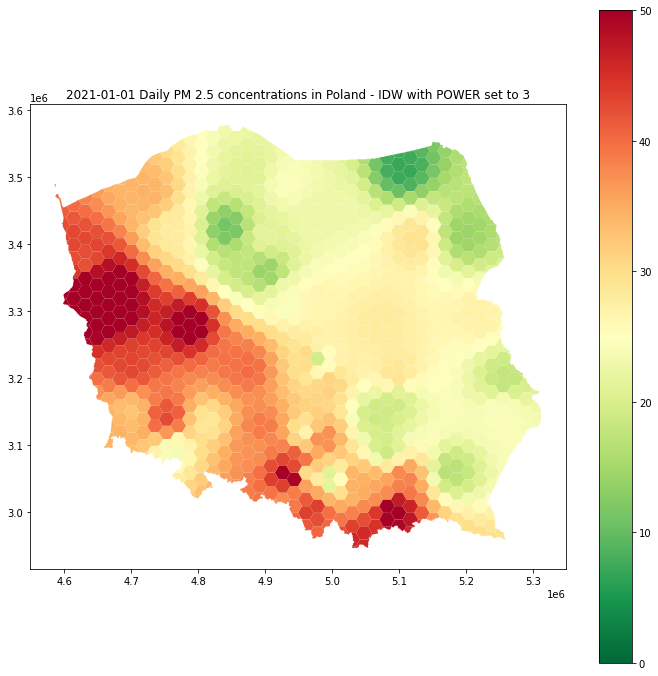

In [38]:
ax = df.plot(column='yhat', legend=True, vmin=0, vmax=50, figsize=(12, 12), cmap='RdYlGn_r')
ax.set_title('2021-01-01 Daily PM 2.5 concentrations in Poland - IDW with POWER set to 3');

In [13]:
# Semivariance

In [18]:
semivar = calculate_semivariance(arr, step_size=STEP_SIZE, max_range=MAX_RANGE)

Model: spherical, error value: 14.7656606198378
Model: exponential, error value: 14.503144188276451
Model: linear, error value: 15.795574110078812
Chosen model: exponential, with value: 14.503144188276451.


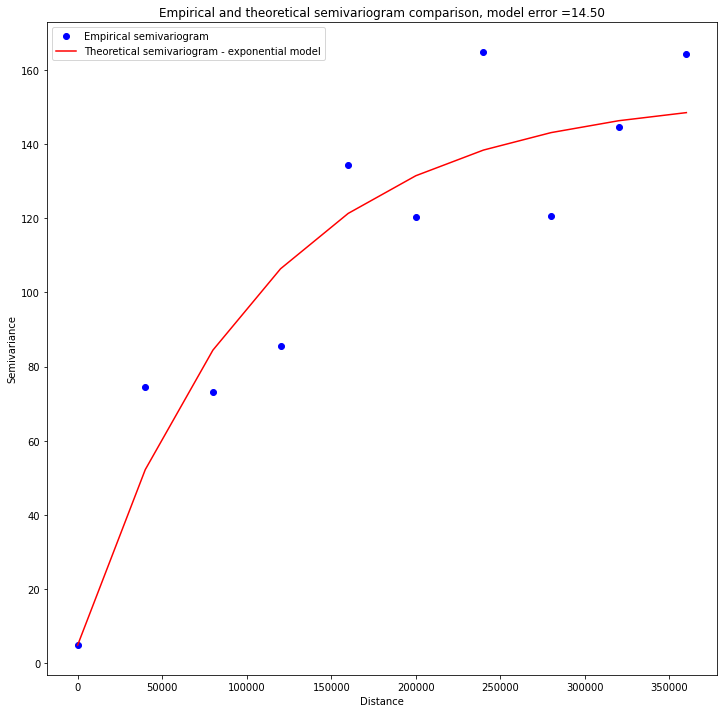

In [19]:
ts = TheoreticalSemivariogram(points_array=arr, empirical_semivariance=semivar, verbose=True)
ts.find_optimal_model()
ts.show_semivariogram()

In [33]:
# Kriging

In [20]:
pk = Krige(ts, arr)

In [31]:
def get_prediction(upts, mdl, nn=8):
    pt = [upts.x, upts.y]
    predicted = mdl.ordinary_kriging(pt, nn)
    return pd.Series([upts, predicted[0], predicted[1]])

# Predict
    
predicted = canvas['points'].apply(get_prediction, mdl=pk)
predicted.columns = ['coordinates', 'yhat', 'error']
    
# Merge with canvas
    
df = canvas.join(predicted)
df = df[['geometry', 'yhat', 'error']]

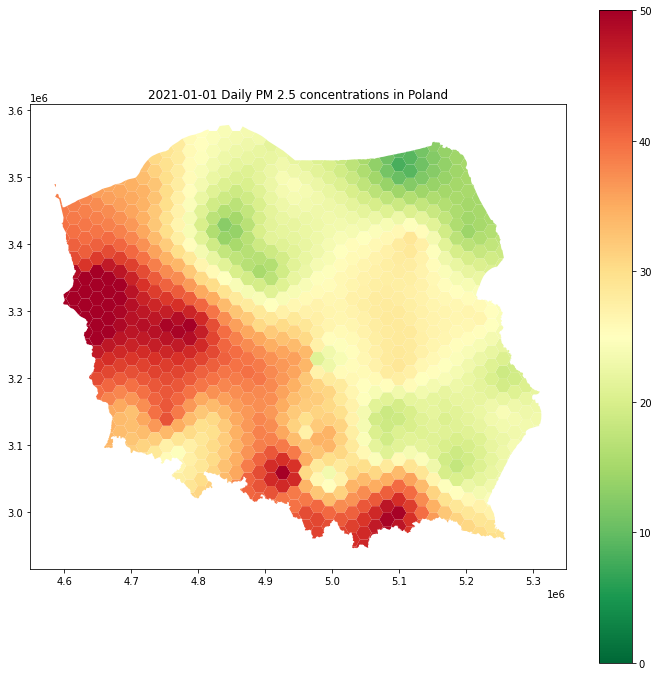

In [32]:
ax = df.plot(column='yhat', legend=True, vmin=0, vmax=50, figsize=(12, 12), cmap='RdYlGn_r')
ax.set_title('2021-01-01 Daily PM 2.5 concentrations in Poland');